# Integer Linear Programming

Integer Linear Programming (ILP) seeks a vector of integer numbers that maximizes (or minimizes) a linear cost function under a set of linear equality or inequality constraints [[1]](#ILP). In other words, it is an optimization problem where the cost function to optimize and all the constraints are linear and the decision variables are integers.


## Mathematical Formulation
The ILP problem can be formulated as follows: given an $n$-dimensional vector $\vec{c} = (c_1, c_2, \ldots, c_n)$, an $m \times n$ matrix $A = (a_{ij})$ with $i=1,\ldots,m$ and $j=1,\ldots,n$, and an $m$-dimensional vector $\vec{b} = (b_1, b_2, \ldots, b_m)$, find an $n$-dimensional vector $\vec{x} = (x_1, x_2, \ldots, x_n)$ with integer entries that maximizes (or minimizes) the cost function:

\begin{align*}
\vec{c} \cdot \vec{x} = c_1x_1 + c_2x_2 + \ldots + c_nx_n
\end{align*}

subject to these constraints:

\begin{align*}
A \vec{x} & \leq \vec{b} \\
x_j & \geq 0, \quad j = 1, 2, \ldots, n \\
x_j & \in \mathbb{Z}, \quad j = 1, 2, \ldots, n
\end{align*}

This tutorial guides you through the steps of solving the problem with the Classiq platform, using QAOA [[2](#QAOA)]. The solution is based on defining a Pyomo model for the optimization problem to solve.

## Building the Pyomo Model from a Graph Input

Define the Pyomo model to use on the Classiq platform, using the mathematical formulation defined above:

In [1]:
import numpy as np
import pyomo.core as pyo


def ilp(a: np.ndarray, b: np.ndarray, c: np.ndarray, bound: int) -> pyo.ConcreteModel:
    # model constraint: a*x <= b
    model = pyo.ConcreteModel()
    assert b.ndim == c.ndim == 1

    num_vars = len(c)
    num_constraints = len(b)

    assert a.shape == (num_constraints, num_vars)

    model.x = pyo.Var(
        # here we bound x to be from 0 to to a given bound
        range(num_vars),
        domain=pyo.NonNegativeIntegers,
        bounds=(0, bound),
    )

    @model.Constraint(range(num_constraints))
    def monotone_rule(model, idx):
        return a[idx, :] @ list(model.x.values()) <= float(b[idx])

    # model objective: max(c * x)
    model.cost = pyo.Objective(expr=c @ list(model.x.values()), sense=pyo.maximize)

    return model

In [2]:
A = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
b = np.array([1, 2, 3])
c = np.array([1, 2, 3])

# Instantiate the model
ilp_model = ilp(A, b, c, 3)

In [3]:
ilp_model.pprint()

1 Var Declarations
    x : Size=3, Index={0, 1, 2}
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     3 : False :  True : NonNegativeIntegers
          1 :     0 :  None :     3 : False :  True : NonNegativeIntegers
          2 :     0 :  None :     3 : False :  True : NonNegativeIntegers

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : Sense    : Expression
        None :   True : maximize : x[0] + 2*x[1] + 3*x[2]

1 Constraint Declarations
    monotone_rule : Size=3, Index={0, 1, 2}, Active=True
        Key : Lower : Body                     : Upper : Active
          0 :  -Inf :       x[0] + x[1] + x[2] :   1.0 :   True
          1 :  -Inf : 2*x[0] + 2*x[1] + 2*x[2] :   2.0 :   True
          2 :  -Inf : 3*x[0] + 3*x[1] + 3*x[2] :   3.0 :   True

3 Declarations: x monotone_rule cost


## Setting Up the Classiq Problem Instance

To solve the Pyomo model defined above, use the `CombinatorialProblem` quantum object. Under the hood it translates the Pyomo model to a quantum model of QAOA, with the cost Hamiltonian translated from the Pyomo model. Choose the number of layers for the QAOA ansatz using the `num_layers` argument. The `penalty_factor` is the coefficient of the constraints term in the cost Hamiltonian.

In [4]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=ilp_model, num_layers=3, penalty_factor=10)

qmod = combi.get_model()

## Synthesizing the QAOA Circuit and Solving the Problem

Synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [5]:
qprog = combi.get_qprog()
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/38w8GTGIHJELpFT0UWvNLftpCI6


https://platform.classiq.io/circuit/38w8GTGIHJELpFT0UWvNLftpCI6?login=True&version=15

Set the quantum backend on which to execute:

In [6]:
from classiq.execution import *

execution_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

Solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of QAOA, define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of QAOA [[3](#cvar)]:

In [7]:
optimized_params = combi.optimize(execution_preferences, maxiter=90, quantile=0.7)

Check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

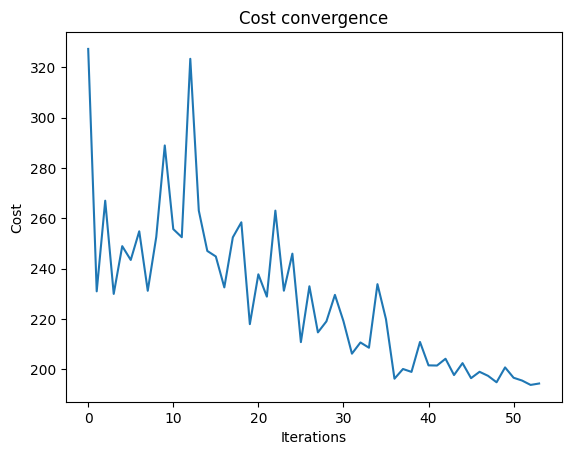

In [8]:
import matplotlib.pyplot as plt

plt.plot(combi.cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")

## Optimization Results

Examine the statistics of the algorithm. The optimization is always defined as a minimization problem, so the positive maximization objective is translated to negative minimization by the Pyomo-to-Qmod translator.

To get samples with the optimized parameters, call the `sample` method:

In [9]:
optimization_result = combi.sample(optimized_params)
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
12,"{'x': [0, 0, 1], 'monotone_rule_1_slack_var': ...",0.012207,-3.0
223,"{'x': [0, 1, 0], 'monotone_rule_1_slack_var': ...",0.000488,-2.0
146,"{'x': [1, 0, 0], 'monotone_rule_1_slack_var': ...",0.001953,-1.0
15,"{'x': [0, 0, 0], 'monotone_rule_1_slack_var': ...",0.011719,0.0
224,"{'x': [0, 0, 1], 'monotone_rule_1_slack_var': ...",0.000488,7.0


Compare the optimized results to uniformly sampled results:

In [10]:
uniform_result = combi.sample_uniform()

And compare the histograms:

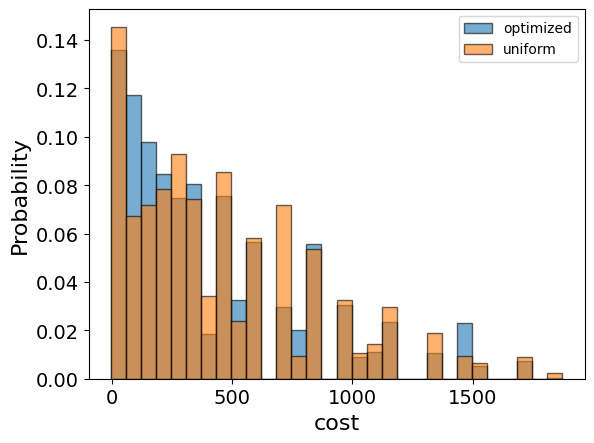

In [11]:
optimization_result["cost"].plot(
    kind="hist",
    bins=30,
    edgecolor="black",
    weights=optimization_result["probability"],
    alpha=0.6,
    label="optimized",
)
uniform_result["cost"].plot(
    kind="hist",
    bins=30,
    edgecolor="black",
    weights=uniform_result["probability"],
    alpha=0.6,
    label="uniform",
)
plt.legend()
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Plot the solution:

In [12]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution

{'x': [0, 0, 1],
 'monotone_rule_1_slack_var': [0],
 'monotone_rule_2_slack_var': [0]}

## Comparing to a Classical Solver

Compare to the classical solution of the problem:

In [13]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(ilp_model)
classical_solution = [int(pyo.value(ilp_model.x[i])) for i in range(len(ilp_model.x))]
print("Classical solution:", classical_solution)

Classical solution: [0, 0, 1]



## References

<a id='MVC'>[1]</a> [Integer Programming (Wikipedia).](https://en.wikipedia.org/wiki/Integer_programming)

<a id='QAOA'>[2]</a> [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. (2014). "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028.](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a> [Barkoutsos, Panagiotis Kl, et al. (2020). "Improving variational quantum optimization using CVaR." Quantum 4: 256.](https://arxiv.org/abs/1907.04769)
